In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

# Suppressing warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Answer 1

# Reading the text file into a dataframe
bank_df = pd.read_csv("Qualitative_Bankruptcy.data.txt", sep = ",", header = None)

In [3]:
# Confirming that the data is loaded correctly
bank_df.head()

,0,1,2,3,4,5,6
0,P,P,A,A,A,P,NB
1,N,N,A,A,A,N,NB
2,A,A,A,A,A,A,NB
3,P,P,P,P,P,P,NB
4,N,N,P,P,P,N,NB


Considering the following column names for each attribute: <br/>
Industrial Risk - IR <br/>
Management Risk - MR <br/>
Financial Flexibility - FF <br/>
Credibility - CR <br/>
Competitiveness - CO <br/>
Operating Risk - OR <br/>

In [4]:
# Giving appropriate headers to each column
bank_df.columns = ["IR", "MR", "FF", "CR", "CO", "OR", "Class"]
bank_df.head()

,IR,MR,FF,CR,CO,OR,Class
0,P,P,A,A,A,P,NB
1,N,N,A,A,A,N,NB
2,A,A,A,A,A,A,NB
3,P,P,P,P,P,P,NB
4,N,N,P,P,P,N,NB


In [5]:
bank_df.shape

(250, 7)

The dataset has 250 rows (entries) and 7 columns (features).

In [6]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
IR       250 non-null object
MR       250 non-null object
FF       250 non-null object
CR       250 non-null object
CO       250 non-null object
OR       250 non-null object
Class    250 non-null object
dtypes: object(7)
memory usage: 13.8+ KB


There are no missing or null values. <br/>
All the attributes are of the type object, they will need to be handled before building any model.

In [7]:
bank_df.describe().T

,count,unique,top,freq
IR,250,3,N,89
MR,250,3,N,119
FF,250,3,N,119
CR,250,3,N,94
CO,250,3,N,103
OR,250,3,N,114
Class,250,2,NB,143


All the columns are string categorical values.<br/>
The number of unique values is 2 for Class and 3 for the rest.<br/>
The value N (Negative) is most frequent in the dataset across all columns.<br/>
The number of entries on bankruptcy (250-143=107) is lesser than non-bankruptcy (143). The target is somewhat balanced.<br/>

In [8]:
# Answer 2

# Encoding the independent features
for feature in bank_df.drop('Class', axis=1).columns: 
    if bank_df[feature].dtype == 'object':
        bank_df[feature] = pd.Categorical(bank_df[feature]).codes

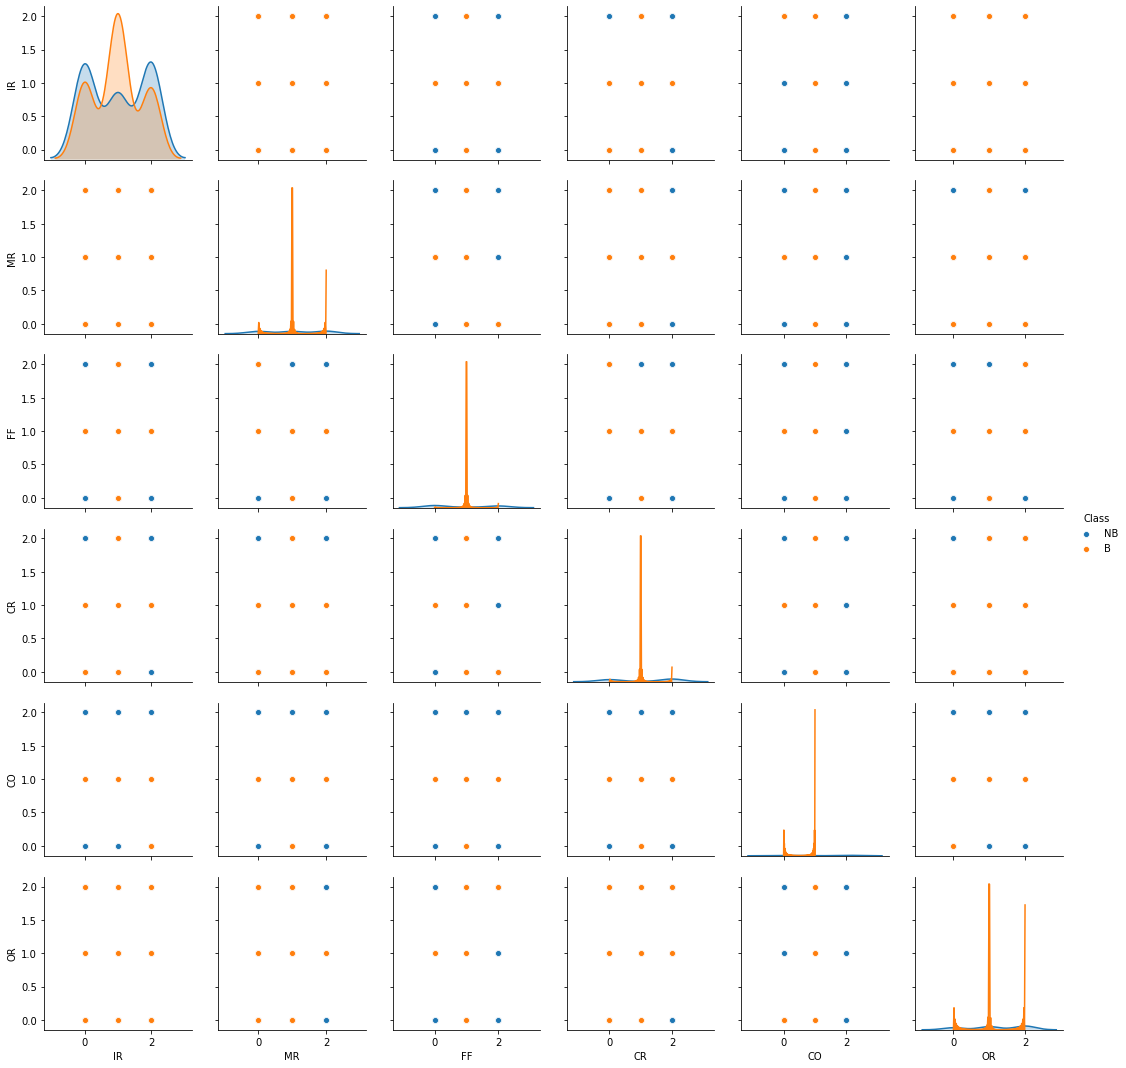

In [9]:
# Pairplotting to see the current relationship among various attributes
sns.pairplot(bank_df, diag_kind='kde', hue='Class') 

There is no linear relationship among independent attributes. <br/>
Also, it looks like the data has come from 3 different gaussians for each class. So, it seems to have at least 6 clusters in all.

In [10]:
# Checking the datatypes again
bank_df.dtypes

IR         int8
MR         int8
FF         int8
CR         int8
CO         int8
OR         int8
Class    object
dtype: object

In [11]:
# Confirming that all the required attributes are encoded
bank_df.head()

,IR,MR,FF,CR,CO,OR,Class
0,2,2,0,0,0,2,NB
1,1,1,0,0,0,1,NB
2,0,0,0,0,0,0,NB
3,2,2,2,2,2,2,NB
4,1,1,2,2,2,1,NB


In [12]:
# Answer 3

# Separating the dependant variable from the rest of the train data
X = bank_df.drop('Class', axis=1)
y = bank_df['Class']

In [13]:
# Answer 4

# Splitting the dataset into training and test data
test = 0.2
seed = 7     
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test, random_state = seed)

In [14]:
# Answer 5

scaler = StandardScaler() 
scaler.fit(X_train)    # Fitting the scaler object using the train data
X_train_scaled = scaler.transform(X_train)    # Transform the train set
X_train.loc[:,:] = X_train_scaled 
pca = PCA().fit(X_train)    # Applying PCA on independent features of train data

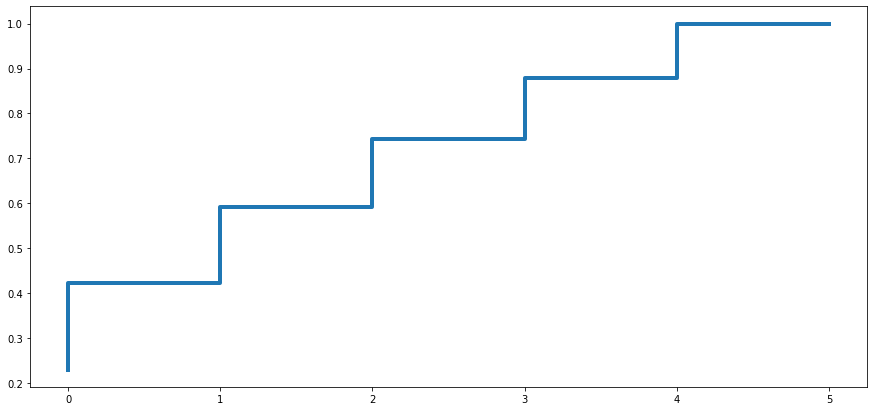

In [15]:
# Answer 6

# Plotting the cumulative variance to decide the optimal number of principal components
plt.figure(figsize= (15,7))
plt.step(x = list(range(6)), y=np.cumsum(pca.explained_variance_ratio_), linewidth = 4)
plt.show()

PCA does not seem to capture enough variance with a reduced set of dimensions. 

In [16]:
# Answer 7

# PCA object, which when fitted will generate principle components such that they capture 95% of the variance 
pca = PCA(.95)  
pca = pca.fit(X_train)

# Transforming the train data using PCA
X_train_pca = pca.transform(X_train)

print('Total number of dimensions in the dataset: ', X_train.shape[1])
print('Number of dimensions after PCA: ', X_train_pca.shape[1])

Total number of dimensions in the dataset:  6
Number of dimensions after PCA:  6


PCA does not seem to work well in this case. If we need to have more than 90% of variance, then we will have to keep all the dimensions.

In [17]:
# Answer 8

# Trying different numbers of clusters
clusters=range(1,10)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k, random_state=seed)
    # Applying KMeans on PCA-transformed data
    model.fit(X_train_pca)
    prediction=model.predict(X_train_pca)
    meanDistortions.append(sum(np.min(cdist(X_train_pca, model.cluster_centers_, 'euclidean'), axis=1)) / X_train_pca.shape[0])


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

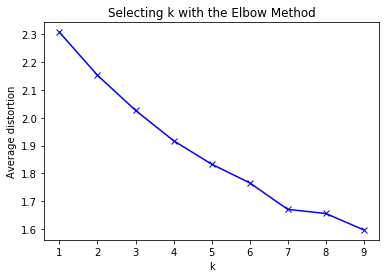

In [18]:
# Answer 9

# Selecting optimal number of clusters through elbow plot
plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

In [19]:
# Forming clusters out of the train data
# Using k = 7 as there seems to be an elbow there
kmeans_model=KMeans(n_clusters=7, random_state=seed)
kmeans_model.fit(X_train_pca)

prediction=kmeans_model.predict(X_train_pca)

In [20]:
# Answer 10

# Append the prediction in a new column 'Group' in train data
X_train['Group'] = prediction

print("Groups Assigned:")
X_train.head()

Groups Assigned:


,IR,MR,FF,CR,CO,OR,Group
240,0.057477,-0.014144,0.057236,-1.321100,-0.168646,-1.494554,3
109,0.057477,-0.014144,-1.373673,-1.321100,-1.517812,-0.123404,2
46,1.334735,-1.428499,1.488146,1.231750,1.180521,-0.123404,5
120,0.057477,-0.014144,-1.373673,1.231750,1.180521,-0.123404,4
247,-1.219781,-0.014144,0.057236,-0.044675,-0.168646,-0.123404,0


In [21]:
# Answer 11

# Scaling and transforming the test data using the same PCA object
X_test_scaled = scaler.transform(X_test)
X_test.loc[:,:] = X_test_scaled
X_test_pca = pca.transform(X_test)

In [22]:
# Answer 12

# Using the same KMeans object to assign predictions to test data
prediction=kmeans_model.predict(X_test_pca)
X_test['Group'] = prediction
print("Groups Assigned:")
X_test.head()

Groups Assigned:


,IR,MR,FF,CR,CO,OR,Group
148,0.057477,-0.014144,0.057236,-1.321100,-0.168646,-1.494554,3
219,-1.219781,-1.428499,0.057236,-0.044675,-0.168646,-0.123404,0
94,1.334735,-1.428499,1.488146,-0.044675,1.180521,-0.123404,5
84,-1.219781,1.400211,-1.373673,-1.321100,-1.517812,1.247747,6
3,1.334735,1.400211,1.488146,1.231750,1.180521,1.247747,5


In [23]:
# Answer 13, 14

# Finding the best hyper-parameters for SVC using GridSearchCV
model = SVC(random_state=seed)
params = {'C': [0.01, 0.1, 0.5, 1, 2, 4, 6, 8, 10], 
          'kernel': ['linear', 'rbf'],
          'gamma' : ['auto', 'scale' ]}
model_new = GridSearchCV(model, param_grid=params, cv=10, iid=False)
model_new.fit(X_train, y_train)
print("Best Hyper Parameters: ", model_new.best_params_)

Best Hyper Parameters:  {'C': 2, 'gamma': 'auto', 'kernel': 'rbf'}


In [24]:
# Building an SVC model with the best hyper-parameters
svm = SVC(C=2, gamma='auto', kernel='rbf', random_state=seed)

In [25]:
# A function to run the model and give us the accuracy scores
def fit_n_print(model, X_train, X_test, y_train, y_test):  
    model.fit(X_train, y_train)   # Fit the model with the train data
    pred = model.predict(X_test)  # Make predictions on the test set
    print("Confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))
    score = round(model.score(X_test, y_test), 3)   # Compute accuracy score for test set
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, pred).ravel()  # Compute the confusion matrix 
    recall = round(tp/(tp+fn), 3)   
    precision = round(tp/(tp+fp), 3)  
    specificity =round(tn/(tn+fp),3) 
    f1_score =  round(2*precision*recall/(precision + recall), 3)
    return score, recall, precision, specificity, f1_score  # Return all the metrics


metrics_svc = fit_n_print(svm, X_train, X_test, y_train, y_test)
print("Score: ", metrics_svc[0])
print("Recall: ", metrics_svc[1])
print("Precision: ", metrics_svc[2])
print("Specificity: ", metrics_svc[3])
print("f1_score: ", metrics_svc[4])

Confusion matrix:
[[16  0]
 [ 0 34]]
Score:  1.0
Recall:  1.0
Precision:  1.0
Specificity:  1.0
f1_score:  1.0


SVM performs extremely well with a perfect score on both classes.<br/>
Thus, we can say that the model will generalize well in production.

In [26]:
# Comparing it with a Logistic model

log_model = LogisticRegression()
metrics_log = fit_n_print(log_model, X_train, X_test, y_train, y_test)
print("Score: ", metrics_log[0])
print("Recall: ", metrics_log[1])
print("Precision: ", metrics_log[2])
print("Specificity: ", metrics_log[3])
print("f1_score: ", metrics_log[4])

Confusion matrix:
[[15  1]
 [ 9 25]]
Score:  0.8
Recall:  0.735
Precision:  0.962
Specificity:  0.938
f1_score:  0.833


Logistic model gives an overall accuracy of ~80% and does not give a great recall. <br/>
SVC is a better performer in this case.